In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler

In [47]:
df = pd.read_csv(r'C:\Users\User\Desktop\Data Science\Deep Learning\data\NSE-Tata-Global-Beverages-Limited.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


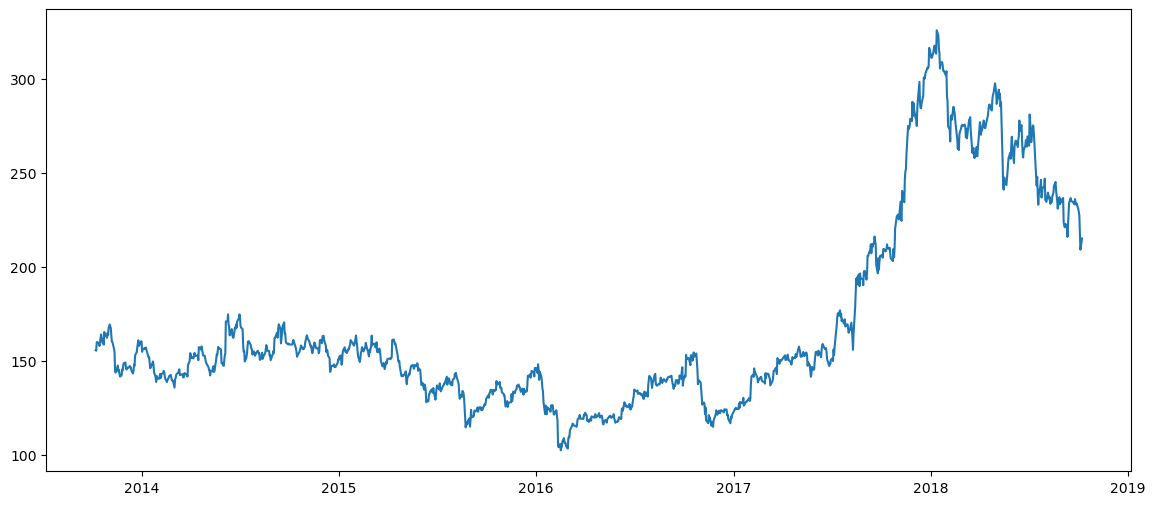

In [48]:
# set date in pandas datetime format and set date as an index
df['Date']= pd.to_datetime(df.Date, format= "%Y-%m-%d")
df.index =df['Date']

plt.figure(figsize = (14, 6))
plt.plot(df["Close"], label = 'Closing Price History')

In [49]:
# create new dataset where we have only column as data and closing price 
data = df.sort_index(ascending = True, axis = 0)
new_dataset=pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

for i in range(0, len(data)):
    new_dataset['Date'][i] = data['Date'][i]
    new_dataset['Close'][i] = data['Close'][i]


In [50]:
# normilize the new filtered data

scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
print(final_dataset)
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset_numeric = final_dataset[:, 1].reshape(-1, 1) # to remove timestamp object as minmaxscalar cannot handle them directly
scaled_data=scaler.fit_transform(final_dataset_numeric)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
print(x_train_data.shape[1])

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0], x_train_data.shape[1],1)) #fix our lookback for lstm as 60

[[Timestamp('2013-10-08 00:00:00') 155.8]
 [Timestamp('2013-10-09 00:00:00') 155.55]
 [Timestamp('2013-10-10 00:00:00') 160.15]
 ...
 [Timestamp('2018-10-04 00:00:00') 218.2]
 [Timestamp('2018-10-05 00:00:00') 209.2]
 [Timestamp('2018-10-08 00:00:00') 215.15]]
60


In [51]:
#bulid the lstm model here and train the model

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss="mean_squared_error", optimizer="adam")
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)


927/927 - 21s - loss: 0.0012 - 21s/epoch - 23ms/step


In [52]:
X_test=[]
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i, 0])
X_test=np.array(X_test)

X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 [==============================] - 1s 19ms/step


In [53]:
lstm_model.save("savedmodel.h5")

C:\Users\User\AppData\Local\Temp\ipykernel_6920\1547348016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_closing_price


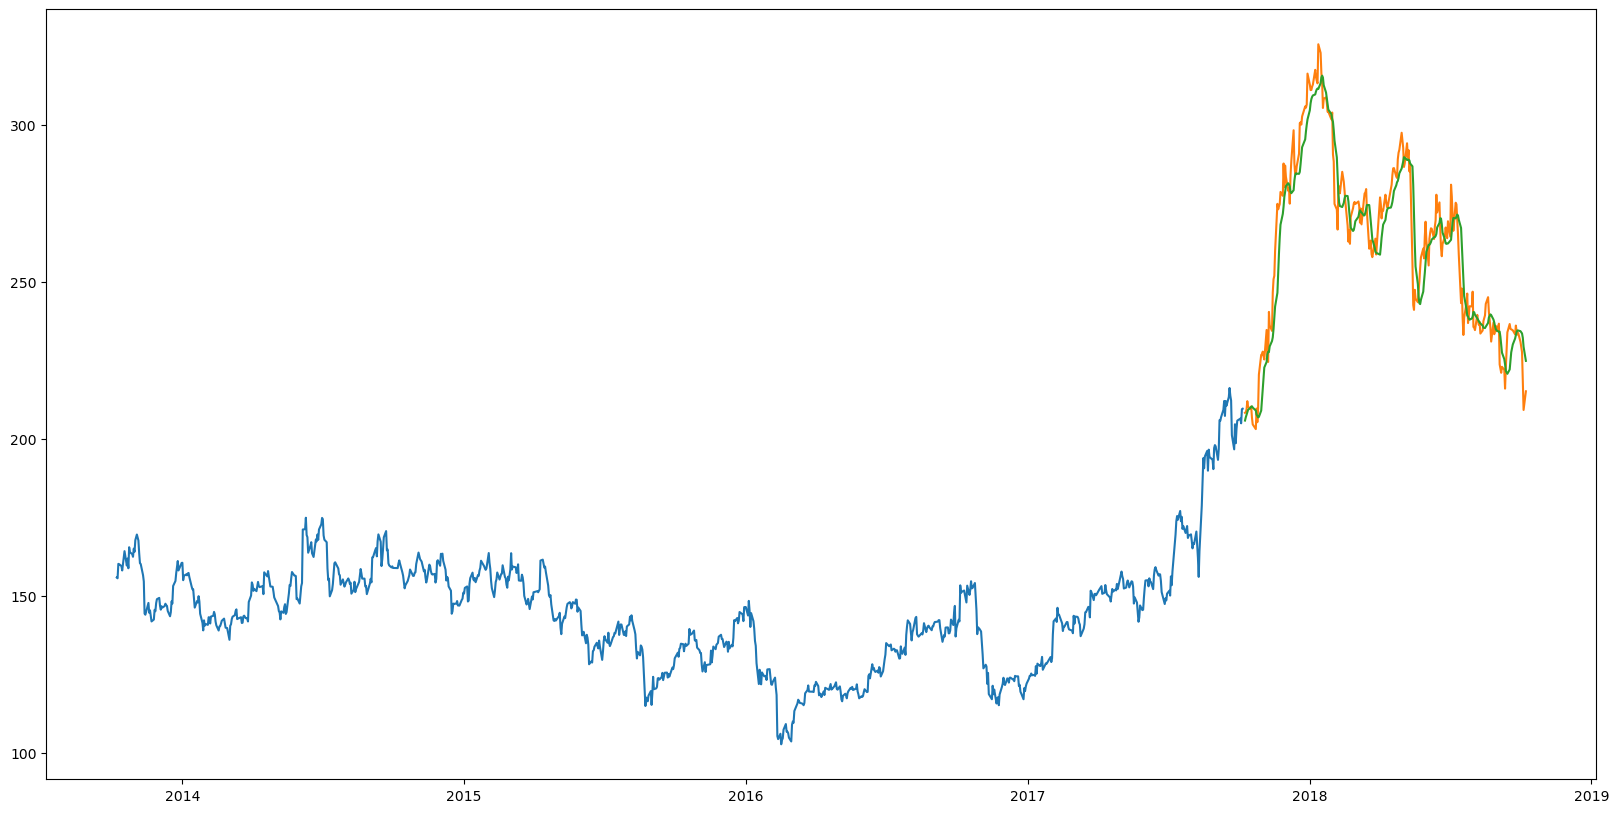

In [58]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions'] = predicted_closing_price
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close', 'Predictions']])